# 数据读取与划分

- 读取 `FS_Preprocessed.xlsx`
- 以 2015-2022 为训练集，2023-2025 为测试集
- 输出舞弊占比，后续准备不平衡处理

In [1]:
import pandas as pd
from pathlib import Path

data_path = Path("FS_Preprocessed.xlsx")
if not data_path.exists():
    raise FileNotFoundError(f"未找到文件: {data_path.resolve()}")

df = pd.read_excel(data_path)

print("数据形状:", df.shape)
print("列名示例:", df.columns[:8].tolist())
print("年份范围:", df["年份"].min(), "-", df["年份"].max())
print("舞弊样本数:", int(df["是否舞弊"].sum()))
print("舞弊比例: {:.2%}".format(df["是否舞弊"].mean()))

数据形状: (267302, 109)
列名示例: ['证券代码', '证券简称', '统计截止日期', '年份', '是否舞弊', '流动资产比率', '现金资产比率', '应收类资产比率']
年份范围: 2015 - 2025
舞弊样本数: 6842
舞弊比例: 2.56%


In [2]:
# 按年份划分训练/测试集
train_df = df[df["年份"].between(2015, 2022, inclusive="both")].copy()
test_df = df[df["年份"].between(2023, 2025, inclusive="both")].copy()
remainder_df = df[~df.index.isin(train_df.index) & ~df.index.isin(test_df.index)].copy()

def show_stats(name, data):
    total = len(data)
    fraud = int(data["是否舞弊"].sum()) if total > 0 else 0
    rate = fraud / total if total > 0 else 0
    print(f"{name}: n={total}, fraud={fraud} ({rate:.2%})")
    if total > 0:
        year_counts = data.groupby("年份")["是否舞弊"].agg(["count", "sum"])
        year_counts.rename(columns={"count": "样本数", "sum": "舞弊数"}, inplace=True)
        print(year_counts)
    print("-")

print("=== 数据切分 ===")
show_stats("Train 2015-2022", train_df)
show_stats("Test 2023-2025", test_df)
if len(remainder_df) > 0:
    show_stats("未纳入(其他年份)", remainder_df)


=== 数据切分 ===
Train 2015-2022: n=190118, fraud=6218 (3.27%)
        样本数  舞弊数
年份              
2015  15437  398
2016  17591  618
2017  23656  908
2018  23276  858
2019  24260  872
2020  27906  964
2021  28956  916
2022  29036  684
-
Test 2023-2025: n=77184, fraud=624 (0.81%)
        样本数  舞弊数
年份              
2023  30709  452
2024  29906  163
2025  16569    9
-


In [3]:
# 不平衡处理准备：特征/标签拆分 + 类别权重
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

info_cols = ["证券代码", "证券简称", "统计截止日期", "年份", "是否舞弊"]
feature_cols = [c for c in df.columns if c not in info_cols]

X_train = train_df[feature_cols].copy()
y_train = train_df["是否舞弊"].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df["是否舞弊"].copy()

classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, class_weights))
print("class_weight 可用于支持的模型 (如 LogisticRegression, RandomForest):", class_weight)

# 如需上采样示例（运行前请确认已安装 imbalanced-learn）：
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"SMOTE 后样本数: {len(X_resampled)}, 舞弊比例: {y_resampled.mean():.2%}")
except ImportError:
    print("如需 SMOTE 上采样，请先 pip install imbalanced-learn")

class_weight 可用于支持的模型 (如 LogisticRegression, RandomForest): {np.int64(0): np.float64(0.5169059271343122), np.int64(1): np.float64(15.287713091026053)}
SMOTE 后样本数: 367800, 舞弊比例: 50.00%


In [4]:
# 欠采样：RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("欠采样后样本数:", len(X_rus))
print("舞弊比例: {:.2%}".format(y_rus.mean()))
print("各类数量:")
print(y_rus.value_counts())

欠采样后样本数: 12436
舞弊比例: 50.00%
各类数量:
是否舞弊
0    6218
1    6218
Name: count, dtype: int64


# LightGBM 模型构建与调参

- 以召回率(Recall)最大化为目标
- 使用网格搜索(GridSearchCV)自动调参
- 参数范围参考经典文献设置

In [5]:
# 导入必要的库
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import precision_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("LightGBM 版本:", lgb.__version__)

LightGBM 版本: 4.6.0


In [6]:
# 检查 LightGBM 是否可用 GPU，并设置 device_type
import numpy as np
import subprocess

use_gpu = True  # 如果明确只想用 CPU，可改为 False

def detect_lgb_gpu():
    if not use_gpu:
        return "cpu"
    # 1) 先看系统是否有 NVIDIA GPU
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
        if result.returncode != 0:
            print("未检测到 nvidia-smi，可能无 NVIDIA GPU。")
            return "cpu"
        print("检测到 NVIDIA GPU：")
        print(result.stdout.splitlines()[0])
    except FileNotFoundError:
        print("未检测到 nvidia-smi，可能无 NVIDIA GPU。")
        return "cpu"
    # 2) 尝试用 LightGBM 进行一次极小训练
    try:
        X_tmp = np.random.rand(100, 5)
        y_tmp = np.random.randint(0, 2, 100)
        dtrain = lgb.Dataset(X_tmp, label=y_tmp)
        lgb.train({"objective": "binary", "device_type": "gpu", "verbose": -1}, dtrain, num_boost_round=1)
        print("LightGBM GPU 可用，将使用 GPU 训练。")
        return "gpu"
    except Exception as e:
        print("LightGBM GPU 不可用，将回退到 CPU。原因:", e)
        return "cpu"

lgb_device_type = detect_lgb_gpu()
print("最终 device_type:", lgb_device_type)

检测到 NVIDIA GPU：
Tue Feb 10 11:28:09 2026       
LightGBM GPU 可用，将使用 GPU 训练。
最终 device_type: gpu


In [7]:
# 使用论文参数范围进行训练
best_model = None
print("将在调参单元中训练模型。")

将在调参单元中训练模型。


In [8]:
# 使用欠采样后的数据进行训练（也可以使用原始数据或SMOTE数据）
# 选择使用哪个数据集：
# 1. X_train, y_train (原始训练数据)
# 2. X_resampled, y_resampled (SMOTE上采样)
# 3. X_rus, y_rus (欠采样)

# 这里我们使用欠采样数据
X_train_final = X_rus
y_train_final = y_rus

print("训练数据形状:", X_train_final.shape)
print("训练数据舞弊比例: {:.2%}".format(y_train_final.mean()))

训练数据形状: (12436, 104)
训练数据舞弊比例: 50.00%


# 按论文参数范围的小网格调参
- 范围依据文献：max_depth 6-20、num_leaves 40-4096、min_child_samples 18-22、min_child_weight 0.001-0.002、feature_fraction 0.6-1.0、bagging_fraction 0.8-1.0、bagging_freq 2-5、reg_alpha 0.001-0.02、reg_lambda 2-8、learning_rate 0.005-0.02、n_estimators 200-500。
- 这里提供一个“精简网格”示例，取每个区间的代表点，避免耗时过长。
- 想运行调参时，把下方 `enable_tuning` 设为 `True`；若想用调参结果参与后续评估，再把 `use_tuned_for_evaluation` 设为 `True`。

In [9]:
# 先做单次训练计时，估算完整网格搜索耗时（不真正开始网格）
from sklearn.model_selection import ParameterGrid
from joblib import cpu_count
import time

# 如果尚未定义参数网格，这里先定义一次，供估算使用
if 'tuning_param_grid' not in globals():
    tuning_param_grid = {
        'max_depth': [6, 8, 10, 14, 20],
        'num_leaves': [40, 64, 128, 256, 512, 1024, 2048, 4096],
        'min_child_samples': [18, 19, 20, 21, 22],
        'min_child_weight': [0.001, 0.002],
        'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
        'bagging_fraction': [0.8, 0.9, 1.0],
        'bagging_freq': [2, 3, 4, 5],
        'reg_alpha': [0.001, 0.01, 0.02],
        'reg_lambda': [2, 4, 6, 8],
        'learning_rate': [0.005, 0.01, 0.02],
        'n_estimators': [200, 300, 400, 500]
    }

# 与调参单元保持一致的设置
cv_folds = 3
n_jobs = -1
effective_jobs = cpu_count() if n_jobs == -1 else n_jobs

# 计算总训练次数
total_combos = len(ParameterGrid(tuning_param_grid))
total_fits = total_combos * cv_folds
print(f"参数组合数: {total_combos:,}")
print(f"总训练次数 (组合数×折数): {total_fits:,}")
print(f"并行进程数估计: {effective_jobs}")

# 单次训练计时（使用当前训练集）
single_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    class_weight=class_weight,
    device_type=lgb_device_type,
    random_state=42,
    verbose=-1
 )

start_time = time.time()
single_model.fit(X_train_final, y_train_final)
single_fit_time = time.time() - start_time
print(f"单次训练耗时: {single_fit_time:.2f} 秒")

# 估算总耗时（并行/串行）
est_parallel_seconds = (total_fits / max(effective_jobs, 1)) * single_fit_time
est_serial_seconds = total_fits * single_fit_time
print(f"预计并行总耗时: {est_parallel_seconds/3600:.2f} 小时")
print(f"预计串行总耗时: {est_serial_seconds/3600:.2f} 小时")

参数组合数: 3,456,000
总训练次数 (组合数×折数): 10,368,000
并行进程数估计: 128
单次训练耗时: 0.76 秒
预计并行总耗时: 17.16 小时
预计串行总耗时: 2196.56 小时


In [10]:
# 分阶段调参（速度优先，避免超长随机搜索）
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import recall_score
import time
import numpy as np

# 留出验证集用于快速评估与早停
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final,
    y_train_final,
    test_size=0.2,
    stratify=y_train_final,
    random_state=42
 )

base_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'class_weight': class_weight,
    'device_type': lgb_device_type,
    'random_state': 42,
    'verbose': -1
}

start_time = time.time()

# Stage 1: 先调树结构（max_depth, num_leaves）
stage1_grid = {
    'max_depth': [6, 8, 10, 14],
    'num_leaves': [31, 63, 127, 255]
}
tuner1 = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**base_params),
    param_distributions=stage1_grid,
    n_iter=8,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
 )
print("Stage 1: 调整 max_depth / num_leaves ...")
tuner1.fit(X_tr, y_tr)
best1 = tuner1.best_params_
print("Stage 1 最优:", best1, "best recall:", f"{tuner1.best_score_:.4f}")

# Stage 2: 再调数据/正则相关参数
stage2_grid = {
    'min_child_samples': [10, 20, 30],
    'min_child_weight': [0.001, 0.01],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'bagging_freq': [2, 4],
    'reg_alpha': [0.0, 0.01],
    'reg_lambda': [1, 2, 4]
}
tuner2 = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**base_params, **best1),
    param_distributions=stage2_grid,
    n_iter=12,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
 )
print("Stage 2: 调整 min_child/feature/bagging/reg ...")
tuner2.fit(X_tr, y_tr)
best2 = tuner2.best_params_
print("Stage 2 最优:", best2, "best recall:", f"{tuner2.best_score_:.4f}")

# Stage 3: 调学习率 + 树数量，使用早停加速
stage3_candidates = [
    {'learning_rate': 0.02, 'n_estimators': 400},
    {'learning_rate': 0.01, 'n_estimators': 800},
    {'learning_rate': 0.005, 'n_estimators': 1600}
 ]
best3 = None
best3_score = -1
for params in stage3_candidates:
    model = lgb.LGBMClassifier(**base_params, **best1, **best2, **params)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='recall',
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    preds = model.predict(X_val)
    score = recall_score(y_val, preds)
    print("Stage 3 candidate:", params, "val recall:", f"{score:.4f}")
    if score > best3_score:
        best3_score = score
        best3 = params

best_params = {**best1, **best2, **best3}
print("最终参数:", best_params)

# 用全部训练集拟合最终模型
best_model = lgb.LGBMClassifier(**base_params, **best_params)
best_model.fit(X_train_final, y_train_final)
elapsed = time.time() - start_time
print(f"分阶段调参完成，耗时: {elapsed/60:.2f} 分钟")

Stage 1: 调整 max_depth / num_leaves ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Stage 1 最优: {'num_leaves': 63, 'max_depth': 6} best recall: 0.9743
Stage 2: 调整 min_child/feature/bagging/reg ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Stage 2 最优: {'reg_lambda': 4, 'reg_alpha': 0.0, 'min_child_weight': 0.01, 'min_child_samples': 30, 'feature_fraction': 0.8, 'bagging_freq': 4, 'bagging_fraction': 0.9} best recall: 0.9887
Stage 3 candidate: {'learning_rate': 0.02, 'n_estimators': 400} val recall: 0.9960
Stage 3 candidate: {'learning_rate': 0.01, 'n_estimators': 800} val recall: 0.9960
Stage 3 candidate: {'learning_rate': 0.005, 'n_estimators': 1600} val recall: 0.9952
最终参数: {'num_leaves': 63, 'max_depth': 6, 'reg_lambda': 4, 'reg_alpha': 0.0, 'min_child_weight': 0.01, 'min_child_samples': 30, 'feature_fraction': 0.8, 'bagging_freq': 4, 'bagging_fraction': 0.9, 'learning_rate': 0.02, 'n_estimators': 400}
分阶段调参完成，耗时: 141.32 分钟


In [11]:
# 确保 best_model 已由调参产生
if 'best_model' in locals() and best_model is not None:
    print("best_model 已设置为调参最优模型。")
else:
    raise RuntimeError("best_model 未生成，请先运行调参单元。")

best_model 已设置为调参最优模型。


In [12]:
# 已按论文参数范围完成训练（网格搜索）。
print("当前模型已由论文参数范围训练完成。")

当前模型已由论文参数范围训练完成。


In [13]:
print("=" * 60)
print("采用的最优参数（网格搜索结果）:")
print("=" * 60)
if 'best_model' in locals() and best_model is not None:
    for param, value in best_model.get_params().items():
        print(f"{param}: {value}")
else:
    print("best_model 未生成，请先运行调参单元。")

print("\n" + "=" * 60)
print("已使用上述参数训练完成。")
print("=" * 60)

采用的最优参数（网格搜索结果）:
boosting_type: gbdt
class_weight: {np.int64(0): np.float64(0.5169059271343122), np.int64(1): np.float64(15.287713091026053)}
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.02
max_depth: 6
min_child_samples: 30
min_child_weight: 0.01
min_split_gain: 0.0
n_estimators: 400
n_jobs: None
num_leaves: 63
objective: binary
random_state: 42
reg_alpha: 0.0
reg_lambda: 4
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0
device_type: gpu
verbose: -1
feature_fraction: 0.8
bagging_freq: 4
bagging_fraction: 0.9

已使用上述参数训练完成。


# 模型评估

在训练集和测试集上评估模型性能

In [14]:
# 在训练集上评估
y_train_pred = best_model.predict(X_train_final)
y_train_proba = best_model.predict_proba(X_train_final)[:, 1]

print("=" * 60)
print("训练集性能评估")
print("=" * 60)
print(f"召回率 (Recall): {recall_score(y_train_final, y_train_pred):.4f}")
print(f"精确率 (Precision): {precision_score(y_train_final, y_train_pred):.4f}")
print(f"F1分数: {f1_score(y_train_final, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train_final, y_train_proba):.4f}")
print("\n混淆矩阵:")
print(confusion_matrix(y_train_final, y_train_pred))
print("\n分类报告:")
print(classification_report(y_train_final, y_train_pred, target_names=['非舞弊', '舞弊']))

训练集性能评估
召回率 (Recall): 1.0000
精确率 (Precision): 0.6036
F1分数: 0.7528
AUC: 0.9367

混淆矩阵:
[[2134 4084]
 [   0 6218]]

分类报告:
              precision    recall  f1-score   support

         非舞弊       1.00      0.34      0.51      6218
          舞弊       0.60      1.00      0.75      6218

    accuracy                           0.67     12436
   macro avg       0.80      0.67      0.63     12436
weighted avg       0.80      0.67      0.63     12436



In [15]:
# 在测试集上评估（2023-2025年数据）
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("=" * 60)
print("测试集性能评估 (2023-2025)")
print("=" * 60)
print(f"召回率 (Recall): {recall_score(y_test, y_test_pred):.4f}")
print(f"精确率 (Precision): {precision_score(y_test, y_test_pred):.4f}")
print(f"F1分数: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\n混淆矩阵:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\n实际舞弊样本数: {int(y_test.sum())}")
print(f"成功识别的舞弊样本数: {cm[1, 1]}")
print(f"未识别的舞弊样本数: {cm[1, 0]}")
print("\n分类报告:")
print(classification_report(y_test, y_test_pred, target_names=['非舞弊', '舞弊']))

测试集性能评估 (2023-2025)
召回率 (Recall): 0.9872
精确率 (Precision): 0.0126
F1分数: 0.0250
AUC: 0.8685

混淆矩阵:
[[28443 48117]
 [    8   616]]

实际舞弊样本数: 624
成功识别的舞弊样本数: 616
未识别的舞弊样本数: 8

分类报告:
              precision    recall  f1-score   support

         非舞弊       1.00      0.37      0.54     76560
          舞弊       0.01      0.99      0.02       624

    accuracy                           0.38     77184
   macro avg       0.51      0.68      0.28     77184
weighted avg       0.99      0.38      0.54     77184



Top 20 重要特征
         特征  重要性
     有形资产比率  470
     无形资产比率  452
 母公司所有者权益占比  424
     固定资产比率  414
    留存收益资产比  414
    应收类资产比率  412
     现金资产比率  411
      财务费用率  410
       流转税率  392
     公司现金流1  379
      销售费用率  354
      管理费用率  320
股东权益对固定资产比率  306
   金融活动利润占比  296
     股权现金流1  296
        市值B  296
    长期资产适合率  279
     保守速动比率  260
     现金适合比率  258
     经营负债比率  255


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS, SimHei
findfont

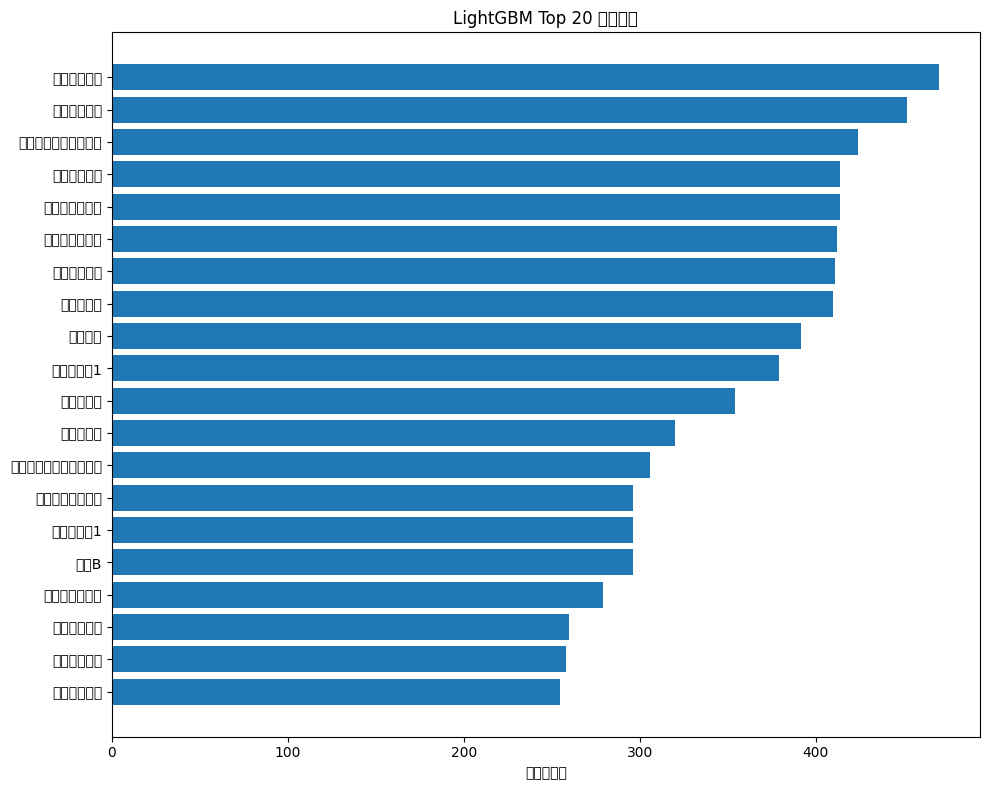

In [16]:
# 特征重要性分析
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False

feature_importance = pd.DataFrame({
    '特征': feature_cols,
    '重要性': best_model.feature_importances_
}).sort_values('重要性', ascending=False)

print("=" * 60)
print("Top 20 重要特征")
print("=" * 60)
print(feature_importance.head(20).to_string(index=False))

# 可视化Top 20特征
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['重要性'].values)
plt.yticks(range(len(top_features)), top_features['特征'].values)
plt.xlabel('特征重要性')
plt.title('LightGBM Top 20 重要特征')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# 保存最优模型
import joblib

model_save_path = "best_lightgbm_model.pkl"
joblib.dump(best_model, model_save_path)
print(f"最优模型已保存至: {model_save_path}")

# 保存特征重要性
feature_importance.to_csv("feature_importance.csv", index=False, encoding='utf-8-sig')
print("特征重要性已保存至: feature_importance.csv")

# 保存测试集预测结果
test_results = test_df[["证券代码", "证券简称", "年份", "是否舞弊"]].copy()
test_results['预测结果'] = y_test_pred
test_results['预测概率'] = y_test_proba
test_results.to_excel("test_predictions.xlsx", index=False)
print("测试集预测结果已保存至: test_predictions.xlsx")

最优模型已保存至: best_lightgbm_model.pkl
特征重要性已保存至: feature_importance.csv
测试集预测结果已保存至: test_predictions.xlsx


# 调参建议

如果完整网格搜索时间过长，可以采用以下策略：

1. **分阶段调参**：先用粗粒度参数范围找到大致区域，再细化搜索
2. **使用RandomizedSearchCV**：随机搜索可以更快地探索参数空间
3. **减少参数组合**：先固定部分参数，逐步调整关键参数
4. **使用早停**：在LightGBM中启用early_stopping_rounds
5. **减少交叉验证折数**：可以从5折改为3折